In [30]:
import pandas as pd
from pandas import read_excel
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
from datetime import date, datetime, timedelta, timezone
import copy
from pandas import IndexSlice as idx
pd.set_option('display.max_columns', None)  # 当列太多时不换行
from numpy import exp, nan
import quantstats as qs

import warnings
warnings.filterwarnings('ignore') # 忽略警告
import pandas as pd
from pandas import IndexSlice as idx



In [37]:
pd.set_option('display.max_columns', None)  # 当列太多时不换行
# df = pd.read_pickle('cb_data.pq') # 导入转债数据
# index = pd.read_pickle('index.pq') # 导入指数数据
df = pd.read_parquet('/Users/yiwei/Desktop/git/cb_data.pq') # 导入转债数据
index = pd.read_parquet('/Users/yiwei/Desktop/git/index.pq') # 导入指数数据

In [38]:
# 基础设置
start_date = '20220801' # 开始日期
end_date = '20250901' # 结束日期
hold_num = 5 # 持有数量
SP = 0.03 # 盘中止盈条件
c_rate =  2 / 1000 # 买卖一次花费的总佣金和滑点（双边）
benchmark = 'index_jsl' # 选择基准，集思录等权:index_jsl, 沪深300:index_300, 中证1000:index_1000, 国证2000:index_2000

In [33]:

# 排除设置
df = df[(df.index.get_level_values('trade_date') >= start_date) & (df.index.get_level_values('trade_date') <= end_date)] # 选择时间范围内数据
df['filter'] = False # 初始化过滤器
df.loc[df.is_call.isin(['已公告强赎', '公告到期赎回','公告实施强赎', '公告提示强赎', '已满足强赎条件']), 'filter'] = True # 排除赎回状态
# df.loc[df.high > 188, 'filter'] = True # 排除收盘价大于150的标的
df.loc[df.close > 155, 'filter'] = True # 排除收盘价大于150的标的
df.loc[df.close < 102, 'filter'] = True # 排除收盘价小于100的标的

df.loc[df.amount < 1000, 'filter'] = True # 排除新债
df.loc[df.volatility < 0.02, 'filter'] = True # 排除新债
df.loc[df.pct_chg > 0.06, 'filter'] = True # 排除新债
df.loc[df.pct_chg < -0.15, 'filter'] = True # 排除新债
df.loc[df.close_stk < 3, 'filter'] = True # 排除新债
# df.loc[df.bias_5 > 0.3, 'filter'] = True # 排除新债
# df.loc[df.redeem_remain_days < 10, 'filter'] = True # 排除新债
# df.loc[df.conv_prem > 0.5, 'filter'] = True # 排除新债
# df.loc[df.remain_size > 30, 'filter'] = True # 排除新债
# df.loc[df.pct_chg > 0.-15, 'filter'] = True # 排除新债
# df.loc[df.pct_chg_5 > 0.3, 'filter'] = True # 排除新债


df.loc[df.left_years < 0.7, 'filter'] = True # 排除新债
df.loc[df.list_days <= 3, 'filter'] = True # 排除新债

In [34]:
df['close_score'] = df.loc[df['filter'] == False, 'close'].groupby('trade_date').rank(ascending=False)
df['conv_prem_score'] = df.loc[df['filter'] == False, 'conv_prem'].groupby('trade_date').rank(ascending=False)
df['remain_size_score'] = df.loc[df['filter'] == False, 'remain_size'].groupby('trade_date').rank(ascending=False)
df['cap_mv_rate_score'] = df.loc[df['filter'] == False, 'cap_mv_rate'].groupby('trade_date').rank(ascending=False)
df['theory_bias_score'] = df.loc[df['filter'] == False, 'theory_bias'].groupby('trade_date').rank(ascending=False)
df['vol_stk_score'] = df.loc[df['filter'] == False, 'vol_stk'].groupby('trade_date').rank(ascending=False)
df['vol_5_score'] = df.loc[df['filter'] == False, 'vol_5'].groupby('trade_date').rank(ascending=False)
df['bias_5_score'] = df.loc[df['filter'] == False, 'bias_5'].groupby('trade_date').rank(ascending=False)
df['turnover_5_score'] = df.loc[df['filter'] == False, 'turnover_5'].groupby('trade_date').rank(ascending=False)
df['turnover_score'] = df.loc[df['filter'] == False, 'turnover'].groupby('trade_date').rank(ascending=False)
df['ytm_score'] = df.loc[df['filter'] == False, 'ytm'].groupby('trade_date').rank(ascending=False)
df['theory_bias_score'] = df.loc[df['filter'] == False, 'theory_bias'].groupby('trade_date').rank(ascending=False)
df['mod_conv_prem_score'] = df.loc[df['filter'] == False, 'mod_conv_prem'].groupby('trade_date').rank(ascending=False)
df['remain_cap_score'] = df.loc[df['filter'] == False, 'remain_cap'].groupby('trade_date').rank(ascending=False)
df['pct_chg_5_score'] = df.loc[df['filter'] == False, 'pct_chg_5'].groupby('trade_date').rank(ascending=False)
df['bond_prem_score'] = df.loc[df['filter'] == False, 'bond_prem'].groupby('trade_date').rank(ascending=False)

df['conv_prem_score'] = df.loc[df['filter'] == False, 'conv_prem'].groupby('trade_date').rank(ascending=False)


df['score'] = df['bond_prem_score'] * -10 + df['ytm_score'] * 10 + df['theory_bias_score'] * -10 + df['cap_mv_rate_score'] * -10 + df['turnover_5_score'] * 15 + df['remain_cap_score'] * -5 + df['vol_stk_score'] * 1 + df['pct_chg_5_score'] * 1


df['rank'] = df.groupby('trade_date')['score'].rank('first', ascending=True) # 按总分从高到低计算排名

In [35]:
code_group = df.groupby('code')
# (2)次日止盈条件
df['aft_open'] = code_group.open.shift(-1) # 计算次日开盘价
df['aft_close'] = code_group.close.shift(-1) # 计算次日收盘价
df['aft_high'] = code_group.high.shift(-1) # 计算次日最高价
df['time_return']= code_group.pct_chg.shift(-1) # 先计算不止盈情况的收益率
df['SFZY']='未满足止盈' #先记录默认情况
pd.set_option('display.max_columns', None)  # 当列太多时不换行

df.loc[df['aft_high'] >= df['close'] * (1+SP),'time_return'] = SP # 满足止盈条件止盈
df.loc[df['aft_open'] >= df['close'] * (1+SP),'time_return'] = \
(df['aft_open']-df['close'])/df['close'] # 开盘满足止盈条件则按开盘价计算涨幅
df.loc[df['aft_high'] >= df['close'] * (1+SP),'SFZY'] = '满足止盈'

# 计算每日信号 采样信号 持仓状态
df.loc[(df['rank'] <= hold_num), 'signal'] = 1 # 标记信号
df.dropna(subset=['signal'], inplace=True) # 删除没有标记的行
df.sort_values(by='trade_date', inplace=True) # 按日期排序

res = pd.DataFrame()
res['time_return'] = df.groupby('trade_date')['time_return'].mean() # 按等权计算组合回报
pd.set_option('display.max_rows',None)
# 计算手续费
pos_df = df['signal'].unstack('code')
pos_df.fillna(0, inplace=True)
res['cost'] = pos_df.diff().abs().sum(axis=1) * c_rate / (pos_df.shift().sum(axis=1) + pos_df.sum(axis=1))
res.iloc[0, 1] = 0.5 * c_rate# 修正首行手续费
res['time_return'] = (res['time_return'] + 1) * (1 - res['cost']) - 1# 扣除手续费及佣金后的回报

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2022-08-02   2022-08-02
End Period                 2025-03-13   2025-03-13
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          1.52%        212.58%
CAGR﹪                     0.4%         35.13%

Sharpe                     0.11         2.89
Prob. Sharpe Ratio         56.89%       100.0%
Smart Sharpe               0.1          2.75
Sortino                    0.15         4.65
Smart Sortino              0.15         4.41
Sortino/√2                 0.11         3.28
Smart Sortino/√2           0.1          3.12
Omega                      1.64         1.64

Max Drawdown               -20.8%       -7.88%
Longest DD Days            918          92
Volatility (ann.)          11.8%        16.18%
R^2                        0.01         0.01
Information Ratio          0.15         0.15
Calmar              

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2024-06-18,2024-06-21,2024-09-06,81,-7.879048,-7.137943
2,2023-11-20,2024-02-02,2024-02-19,92,-7.842808,-6.644850
3,2024-10-08,2024-10-10,2024-10-17,10,-6.820057,-4.811829
4,2022-08-17,2022-08-31,2022-10-12,57,-5.424988,-5.411146
5,2024-12-12,2025-01-03,2025-02-05,56,-4.723379,-4.322997


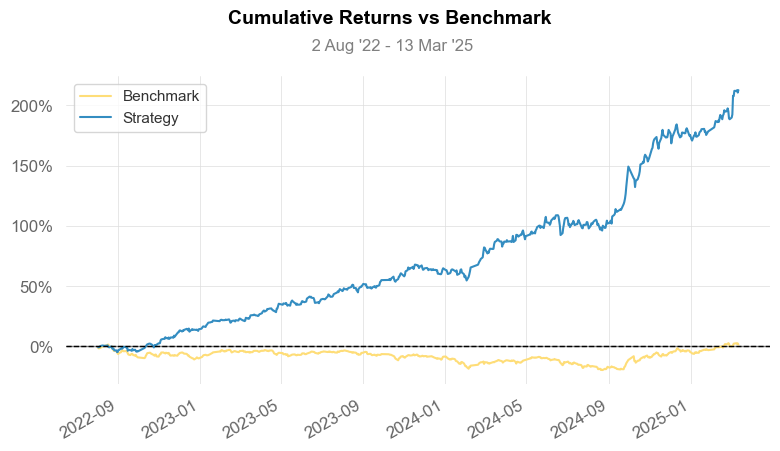

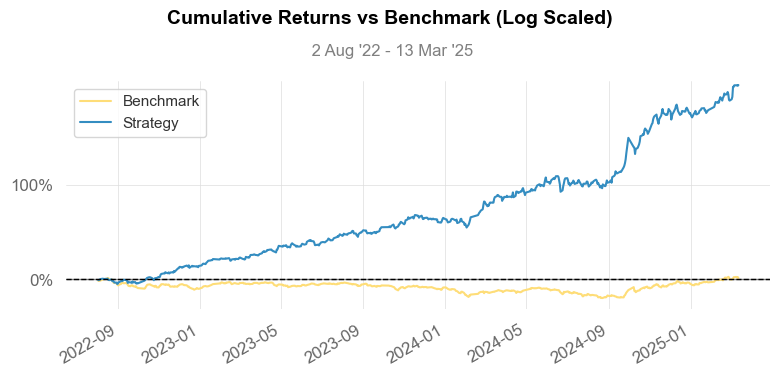

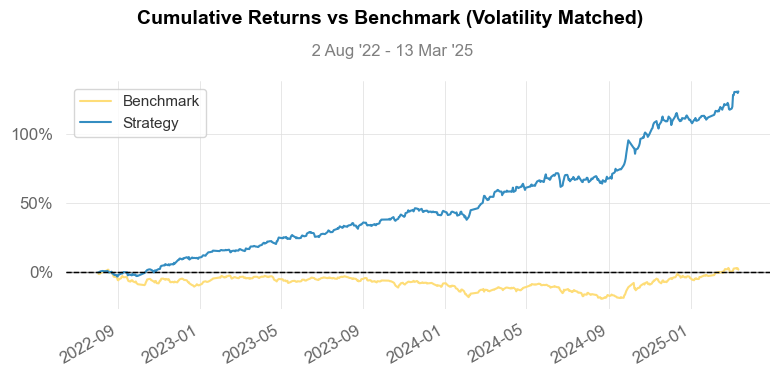

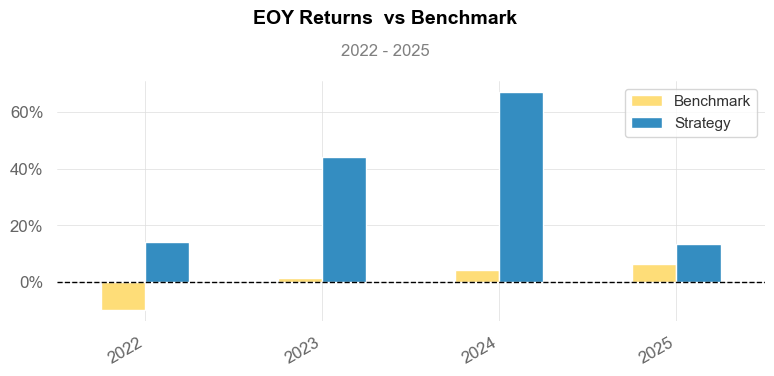

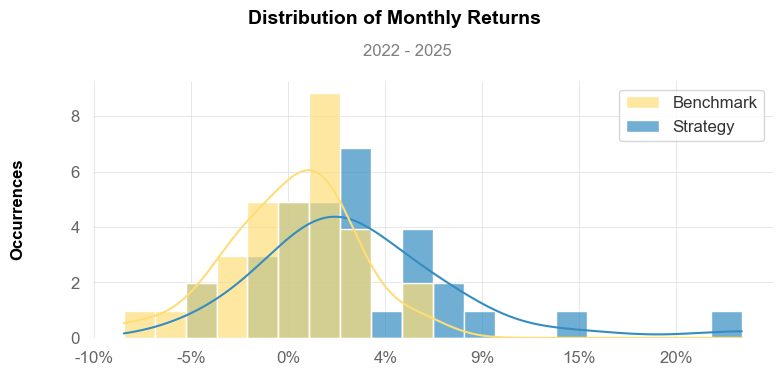

UnsupportedFunctionCall: numpy operations are not valid with resample. Use .resample(...).sum() instead

In [36]:
# qs.reports.full(res.time_return, benchmark=index[benchmark], periods_per_year=12)
qs.reports.full(res.time_return, benchmark=index[benchmark])

# # 1. 基础指标计算
# returns = res.time_return
# benchmark_returns = index[benchmark]
# benchmark_returns = benchmark_returns.reindex(returns.index)
# excess_returns = returns - benchmark_returns

# # 2. 计算月度和年度数据
# monthly_returns = (1 + returns).resample('M').prod() - 1
# yearly_returns = (1 + returns).resample('Y').prod() - 1
# yearly_benchmark = (1 + benchmark_returns).resample('Y').prod() - 1

# # 3. 分开创建图表，避免布局问题
# def plot_cumulative_returns():
#     plt.figure(figsize=(12, 6))
#     cum_returns = (1 + returns).cumprod()
#     cum_benchmark = (1 + benchmark_returns).cumprod()
    
#     plt.plot(cum_returns.index, cum_returns, label='策略')
#     plt.plot(cum_benchmark.index, cum_benchmark, label='基准', alpha=0.7)
#     plt.title('累积收益对比')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

# def plot_drawdown():
#     plt.figure(figsize=(12, 6))
    
#     def calculate_drawdown(returns):
#         cum_returns = (1 + returns).cumprod()
#         rolling_max = cum_returns.expanding().max()
#         drawdowns = cum_returns / rolling_max - 1
#         return drawdowns
    
#     dd_strategy = calculate_drawdown(returns)
#     dd_benchmark = calculate_drawdown(benchmark_returns)
    
#     plt.plot(dd_strategy.index, dd_strategy, label='策略回撤', color='red')
#     plt.plot(dd_benchmark.index, dd_benchmark, label='基准回撤', color='blue', alpha=0.7)
#     plt.title('回撤分析')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

# def plot_monthly_heatmap():
#     if monthly_returns.empty:
#         print("数据不足，无法生成月度热力图")
#         return
        
#     monthly_returns.index = monthly_returns.index.strftime('%Y-%m')
#     monthly_returns_matrix = monthly_returns.groupby([monthly_returns.index.str[:4], 
#                                                     monthly_returns.index.str[5:]]).first().unstack()
    
#     if monthly_returns_matrix.empty:
#         print("数据不足，无法生成月度热力图")
#         return
        
#     plt.figure(figsize=(12, 8))
#     im = plt.imshow(monthly_returns_matrix, cmap='RdYlGn', aspect='auto')
#     plt.colorbar(im, format='{:.1%}')
    
#     plt.title('月度收益热力图')
#     if len(monthly_returns_matrix.columns) > 0:
#         plt.xticks(range(len(monthly_returns_matrix.columns)), 
#                   monthly_returns_matrix.columns, rotation=45)
#     if len(monthly_returns_matrix.index) > 0:
#         plt.yticks(range(len(monthly_returns_matrix.index)), 
#                   monthly_returns_matrix.index)
    
#     for i in range(len(monthly_returns_matrix.index)):
#         for j in range(len(monthly_returns_matrix.columns)):
#             value = monthly_returns_matrix.iloc[i, j]
#             if pd.notna(value):
#                 plt.text(j, i, f'{value:.1%}', ha='center', va='center',
#                         color='black' if abs(value) < 0.1 else 'white')
#     plt.show()

# def plot_yearly_comparison():
#     if yearly_returns.empty:
#         print("数据不足，无法生成年度对比图")
#         return
        
#     plt.figure(figsize=(12, 6))
#     years = yearly_returns.index.year
#     x = np.arange(len(years))
#     width = 0.35
    
#     plt.bar(x - width/2, yearly_returns, width, label='策略收益', color='green', alpha=0.6)
#     plt.bar(x + width/2, yearly_benchmark, width, label='基准收益', color='blue', alpha=0.6)
    
#     # 添加年度最大回撤
#     yearly_max_dd = []
#     yearly_benchmark_dd = []
    
#     for year in years:
#         year_returns = returns[returns.index.year == year]
#         year_benchmark = benchmark_returns[benchmark_returns.index.year == year]
        
#         dd_strat = calculate_drawdown(year_returns).min()
#         dd_bench = calculate_drawdown(year_benchmark).min()
#         yearly_max_dd.append(dd_strat)
#         yearly_benchmark_dd.append(dd_bench)
    
#     plt.plot(x, yearly_max_dd, 'r--', label='策略最大回撤', marker='o')
#     plt.plot(x, yearly_benchmark_dd, 'b--', label='基准最大回撤', marker='o')
    
#     plt.title('年度收益与最大回撤对比')
#     plt.xticks(x, years, rotation=45)
#     plt.legend()
#     plt.grid(True)
    
#     # 添加标签
#     for i, v in enumerate(yearly_returns):
#         plt.text(i - width/2, v, f'{v:.1%}', ha='center', va='bottom')
#     for i, v in enumerate(yearly_benchmark):
#         plt.text(i + width/2, v, f'{v:.1%}', ha='center', va='bottom')
    
#     plt.show()

# # 4. 输出统计信息
# print("\n=== 策略绩效分析 ===")
# print("\n基本指标:")
# print(f"累计收益率: {qs.stats.comp(returns):.2%}")
# print(f"年化收益率: {qs.stats.cagr(returns):.2%}")
# print(f"夏普比率: {qs.stats.sharpe(returns):.2f}")
# print(f"索提诺比率: {qs.stats.sortino(returns):.2f}")
# print(f"最大回撤: {qs.stats.max_drawdown(returns):.2%}")
# print(f"年化波动率: {qs.stats.volatility(returns, periods=252):.2%}")
# print(f"胜率: {len(returns[returns > 0]) / len(returns):.2%}")

# print("\n月度统计:")
# if not monthly_returns.empty:
#     print(f"最佳月度收益: {monthly_returns.max():.2%}")
#     print(f"最差月度收益: {monthly_returns.min():.2%}")
#     print(f"平均月度收益: {monthly_returns.mean():.2%}")
#     print(f"月度收益标准差: {monthly_returns.std():.2%}")
#     print(f"正收益月份占比: {len(monthly_returns[monthly_returns > 0]) / len(monthly_returns):.2%}")

# print("\n年度统计:")
# if not yearly_returns.empty:
#     print(f"最佳年度收益: {yearly_returns.max():.2%}")
#     print(f"最差年度收益: {yearly_returns.min():.2%}")
#     print(f"平均年度收益: {yearly_returns.mean():.2%}")
#     print(f"年度收益标准差: {yearly_returns.std():.2%}")
#     print(f"正收益年份占比: {len(yearly_returns[yearly_returns > 0]) / len(yearly_returns):.2%}")

# # 5. 绘制所有图表
# plot_cumulative_returns()
# plot_drawdown()
# plot_monthly_heatmap()
# plot_yearly_comparison()

In [108]:
# 查看某个交易日选出的标的
df.loc[idx[:,'2025-03-13'],:].sort_values(by='rank') # 查看某日

,,name,pre_close,open,high,low,close,limit,close_ma_5,bias_5,pct_chg,adj_factor,vol,vol_5,amount,amount_5,volatility,code_stk,name_stk,pre_close_stk,open_stk,high_stk,low_stk,close_stk,pct_chg_stk,adj_factor_stk,vol_stk,amount_stk,pe_ttm,pb,ps_ttm,dv_ratio,total_share,float_share,total_mv,circ_mv,debt_to_assets,volatility_stk,is_call,conv_price,conv_value,conv_prem,dblow,issue_size,remain_size,remain_cap,turnover,turnover_5,cap_mv_rate,list_date,list_days,conv_start_date,left_conv_start_days,conv_end_date,left_years,ytm,pure_value,bond_prem,option_value,theory_value,theory_bias,rating,yy_rating,orgform,area,industry_1,industry_2,industry_3,maturity_put_price,maturity,popularity_ranking,pct_chg_5,pct_chg_5_stk,alpha_pct_chg_5,theory_conv_prem,mod_conv_prem,open_pct_chg,high_pct_chg,low_pct_chg,max_value,max_value_position,filter,zhengfu,natr_1,natr_3,natr_5,natr_10,natr_20,zhengfu_cha,aft_high1,aft_high_cur_close,turnover_pct,cap_float_share_rate,pct_chg_20,pct_chg_stk_20,turnover_5_avg,turnover_10_avg,turnover_20_avg,turnover_60_avg,rolling_1_avg,rolling_5_avg,rolling_20_avg,rolling_50_avg,rolling_1_to_5_avg,rolling_5_to_20_avg,rolling_20_to_50_avg,turnover_pct_5_avg,bodong_60,bodong_20,bodong_20_to_bodong_60,bodong_20_bd,bodong_10,bodong_10_bd,bodong_5_bd,zhengfu_1,zhengfu_5,zhengfu_10,zhengfu_20,zhengfu_60,zhengfu_1_bodong,zhengfu_5_bodong,zhengfu_10_bodong,zhengfu_20_bodong,zhengfu_60_bodong,high_jump,close_drop,high_jump_count_100,close_drop_count_100,high_jump_count_250,close_drop_count_250,high_jump_count_100_pct,high_jump_count_250_pct,SDZ,close_score,conv_prem_score,remain_size_score,cap_mv_rate_score,theory_bias_score,vol_stk_score,vol_5_score,bias_5_score,turnover_5_score,turnover_score,max_value_position_score,high_jump_count_100_score,close_drop_count_100_score,high_jump_count_250_score,close_drop_count_250_score,bond_prem_score,ytm_score,mod_conv_prem_score,natr_1_score,natr_3_score,natr_5_score,natr_10_score,natr_20_score,remain_cap_score,pct_chg_5_score,zhengfu_5_bodong_score,zhengfu_10_bodong_score,zhengfu_20_bodong_score,zhengfu_60_bodong_score,alpha_pct_chg_5_score,score,rank,aft_open,aft_close,aft_high,time_return,SFZY,signal
code,trade_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
127061.SZ,2025-03-13,美锦转债,103.476,103.40,109.998,103.376,109.007,0,103.7292,0.050881,0.053452,1.097603,1050709.3,2030060.7,113751.896093,214279.054125,0.220825,000723.SZ,美锦能源,4.60,4.60,5.06,4.60,5.06,0.100000,0.440075,2349132.11,1159219.352,NaN,1.5636,1.1022,0.000000,443139.6033,439619.8913,224.228639,222.447665,0.630037,0.392389,None,5.26,96.197719,0.133156,122.322577,35.9000,27.893516,30.405885,0.374111,0.722613,0.135602,2022-05-30,1019,2022-10-26,-869,2028-04-19,3.106849,0.040310,111.258807,-0.020239,26.837467,138.096275,-0.266857,AA-,7-,大型民企,山西,化石能源,煤炭,焦炭,118.0,6.0,7,0.109644,0.204762,-0.095118,0.249689,-0.116533,-0.000734,0.063029,-0.000966,120.500,0.904622,False,0.060748,6.622,3.078644,2.381901,1.714768,1.399535,0.176743,110.378,0.012577,0.880081,0.136688,0.086994,0.165899,0.144523,0.079512,0.049555,0.034466,0.880081,0.650781,0.349512,0.349397,1.352345,1.861971,1.000330,0.650781,0.191939,0.156617,0.815976,0.078192,0.148120,0.072071,0.064147,NaN,0.024466,0.020084,0.014890,0.010047,NaN,0.054708,0.063512,0.066590,0.077822,True,False,4.0,3.0,18.0,11.0,0.351626,0.436992,3445.460404,292.0,220.0,32.0,151.0,290.0,1.0,5.0,1.0,53.0,20.0,93.0,223.5,144.5,188.0,155.0,298.0,2.0,293.0,24.0,42.0,78.0,158.0,222.0,35.0,1.0,6.0,24.0,52.0,113.0,291.0,-6748.0,1.0,108.000,108.830,110.378,-0.001624,未满足止盈,1.0
123104.SZ,2025-03-13,卫宁转债,124.258,124.00,124.097,122.136,122.970,0,124.1038,-0.009136,-0.010366,1.249269,61384.4,1247024.1,7543.917370,158762.323908,0.099274,300253.SZ,卫宁健康,12.46,12.37,12.46,11.85,12.12,-0.027287,0.754113,1497523.66,1808172.598,73.7111,4.6468,8.3616,0.001616,219098.3182,189123.7371,265.547162,229.21